# **Final Project - Machine Learning**

Ioana Zaharie-Iosif, Analiza Datelor Complexe, 2026

### **Final Project Task 1 - Census Data Preprocessing**

## objectives
- load and explore the Census dataset
- handle missing values
- correct errors and remove duplicates
- detect and treat outliers
- engineer new features
- encode categorical variables
- normalize/standardize numerical features
- split data into train/test sets and save

**Target Variable:** `hours-per-week` (Regression task)


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported.")

Libraries imported.


#### 1. Load Data
Load the Census (Adult) dataset from UCI Machine Learning Repository.

In [35]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", 
    "marital-status", "occupation", "relationship", "race", "sex", 
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 1.2. Data types

Let us look at the data types in the DataFrame. This way, we can understand what we're actually working with. :P

In [36]:
print("Dataset Info:")
print(data.info())
print(f"\nData types:\n{data.dtypes}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

Data types:
age                int64
workclass         object
fnlwgt     

### 2-3-4. Handle Missing Values, errors and duplicates
our **strategy:** Identify missing values (marked as "?") and remove rows with missing data.
Missing values represent ~7% of the dataset, so removal is acceptable. The threshold depends on the total number of entries, usually. For this dataset it should be fine.

In [37]:
missing_counts = data.isnull().sum()
missing_percentages = (data.isnull().sum() / len(data)) * 100

missing_df = pd.DataFrame({
    'Column': data.columns,
    'Missing Count': missing_counts.values,
    'Percentage (%)': missing_percentages.values
})

# show only columns with missing values
missing_summary = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_summary.to_string(index=False))

# removing rows with missing values
data_clean = data.dropna()
print(f"Removed {len(data) - len(data_clean)} rows with missing values")
print(f"New shape: {data_clean.shape}")

print("=" * 60) # am invatat acest truc

duplicates = data_clean.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")

if duplicates > 0:
    data_clean = data_clean.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")

for col in data_clean.select_dtypes(include='object').columns:
    data_clean[col] = data_clean[col].str.strip()

print(f"after cleaning: {data_clean.shape}")

Empty DataFrame
Columns: [Column, Missing Count, Percentage (%)]
Index: []
Removed 0 rows with missing values
New shape: (32561, 15)
Duplicate rows found: 24
Removed 24 duplicate rows
after cleaning: (32537, 15)


Using the **IQR method** to detect outliers in numerical features.

- Keep outliers in the target variable (hours-per-week) but cap extreme values
- Document outlier percentages for all numerical features

In [38]:
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

def detect_outliers_iqr(df, column):
    """detect outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# detect outliers in all numerical columns
outlier_summary = []
for col in numerical_cols:
    n_outliers, lower, upper = detect_outliers_iqr(data_clean, col)
    outlier_summary.append({
        'Feature': col,
        'Outliers': n_outliers,
        'Percentage': f"{(n_outliers / len(data_clean)) * 100:.2f}%",
        'Lower Bound': f"{lower:.2f}",
        'Upper Bound': f"{upper:.2f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

       Feature  Outliers Percentage Lower Bound Upper Bound
           age       142      0.44%       -2.00       78.00
        fnlwgt       993      3.05%   -60922.00   415742.00
 education-num      1193      3.67%        4.50       16.50
  capital-gain      2712      8.34%        0.00        0.00
  capital-loss      1519      4.67%        0.00        0.00
hours-per-week      9002     27.67%       32.50       52.50


In [39]:
p1 = data_clean['hours-per-week'].quantile(0.01)
p99 = data_clean['hours-per-week'].quantile(0.99)

print(f"\ntarget variable (hours-per-week) outlier treatment:")
print(f"  original range: [{data_clean['hours-per-week'].min()}, {data_clean['hours-per-week'].max()}]")
print(f"  capping to: [{p1}, {p99}] (1st and 99th percentiles)")

data_clean['hours-per-week'] = data_clean['hours-per-week'].clip(p1, p99)

print(f"new range: [{data_clean['hours-per-week'].min()}, {data_clean['hours-per-week'].max()}]")


target variable (hours-per-week) outlier treatment:
  original range: [1, 99]
  capping to: [8.0, 80.0] (1st and 99th percentiles)
new range: [8, 80]


### 5. Feature Engineering

1. **age_group**: categorical age ranges (young, adult, middle_aged, senior)
2. **has_capital_gain**: binary indicator for capital gains > 0
3. **has_capital_loss**: binary indicator for capital losses > 0
4. **net_capital**: net capital (gain - loss)
5. **work_intensity**: work hour categories (part_time, full_time, overtime, extreme)
6. **education_level**: simplified education grouping (low, medium, high)

In [40]:
# 1. age groups
data_clean['age_group'] = pd.cut(data_clean['age'], 
                                  bins=[0, 25, 35, 50, 100], 
                                  labels=['young', 'adult', 'middle_aged', 'senior'])


# 2. capital indicators
data_clean['has_capital_gain'] = (data_clean['capital-gain'] > 0).astype(int)
data_clean['has_capital_loss'] = (data_clean['capital-loss'] > 0).astype(int)

# 3. net capital
data_clean['net_capital'] = data_clean['capital-gain'] - data_clean['capital-loss']

# 4. work intensity categories
data_clean['work_intensity'] = pd.cut(data_clean['hours-per-week'], 
                                       bins=[0, 20, 40, 60, 100], 
                                       labels=['part_time', 'full_time', 'overtime', 'extreme'])

# 5. education level grouping
education_mapping = {
    'preschool': 'low', '1st-4th': 'low', '5th-6th': 'low', '7th-8th': 'low',
    '9th': 'medium', '10th': 'medium', '11th': 'medium', '12th': 'medium',
    'HS-grad': 'medium', 'some-college': 'medium', 'assoc-voc': 'medium', 'assoc-acdm': 'medium',
    'bachelors': 'high', 'masters': 'high', 'Prof-school': 'high', 'doctorate': 'high'
}
data_clean['education_level'] = data_clean['education'].map(education_mapping)

print(f"total features now: {data_clean.shape[1]}")

print("\nsample of engineered features:")
data_clean[['age', 'age_group', 'capital-gain', 'has_capital_gain', 
            'hours-per-week', 'work_intensity', 'education', 'education_level']].head(10)

total features now: 21

sample of engineered features:


,age,age_group,capital-gain,has_capital_gain,hours-per-week,work_intensity,education,education_level
0,39,middle_aged,2174,1,40,full_time,Bachelors,NaN
1,50,middle_aged,0,0,13,part_time,Bachelors,NaN
2,38,middle_aged,0,0,40,full_time,HS-grad,medium
3,53,senior,0,0,40,full_time,11th,medium
4,28,adult,0,0,40,full_time,Bachelors,NaN
5,37,middle_aged,0,0,40,full_time,Masters,NaN
6,49,middle_aged,0,0,16,part_time,9th,medium
7,52,senior,0,0,45,overtime,HS-grad,medium
8,31,adult,14084,1,50,overtime,Masters,NaN
9,42,middle_aged,5178,1,40,full_time,Bachelors,NaN


### 6. Encode Categorical Variables
Using **label encoding** for all categorical features to convert them into numerical format.
label encoding is suitable here because:
- many algorithms require numerical input
- we have ordinal relationships in some features (education_level)
- tree-based models handle encoded categories well

In [41]:

X = data_clean.drop('hours-per-week', axis=1)
y = data_clean['hours-per-week']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

categorical_cols = X.select_dtypes(include='object').columns.tolist()
categorical_cols += ['age_group', 'work_intensity', 'education_level']

print(f"\nCategorical columns to encode: {len(categorical_cols)}")
print(f"Columns: {categorical_cols}")

Features shape: (32537, 20)
Target shape: (32537,)

Categorical columns to encode: 13
Columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income', 'education_level', 'age_group', 'work_intensity', 'education_level']


In [42]:
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

print(f"Successfully encoded {len(categorical_cols)} categorical features")

print(f"\nExample - 'workclass' encoding:")
sample_original = X['workclass'].head(10).values
sample_encoded = X_encoded['workclass'].head(10).values
for orig, enc in zip(sample_original, sample_encoded):
    print(f"  {orig:20s} -> {enc}")

Successfully encoded 13 categorical features

Example - 'workclass' encoding:
  State-gov            -> 7
  Self-emp-not-inc     -> 6
  Private              -> 4
  Private              -> 4
  Private              -> 4
  Private              -> 4
  Private              -> 4
  Self-emp-not-inc     -> 6
  Private              -> 4
  Private              -> 4


### 7. Normalization / Standardization
Using **StandardScaler** to normalize numerical features.

In [43]:
numerical_feats = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'net_capital']

print(f"Features to scale: {numerical_feats}")
print(f"\nBefore scaling (sample statistics):")
print(X_encoded[numerical_feats].describe().loc[['mean', 'std', 'min', 'max']])

# Apply StandardScaler
scaler_X = StandardScaler()
X_encoded[numerical_feats] = scaler_X.fit_transform(X_encoded[numerical_feats])

print(f"\n✓ standardized {len(numerical_feats)} numerical features")
print(f"\nafter scaling (sample statistics):")
print(X_encoded[numerical_feats].describe().loc[['mean', 'std', 'min', 'max']])

Features to scale: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'net_capital']

Before scaling (sample statistics):
            age        fnlwgt  education-num  capital-gain  capital-loss  \
mean  38.585549  1.897808e+05      10.081815   1078.443741     87.368227   
std   13.637984  1.055565e+05       2.571633   7387.957424    403.101833   
min   17.000000  1.228500e+04       1.000000      0.000000      0.000000   
max   90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       net_capital  
mean    991.075514  
std    7411.670204  
min   -4356.000000  
max   99999.000000  

✓ standardized 6 numerical features

after scaling (sample statistics):
               age        fnlwgt  education-num  capital-gain  capital-loss  \
mean -7.555945e-17 -1.255685e-16   2.849858e-17  3.646945e-17  4.367598e-19   
std   1.000015e+00  1.000015e+00   1.000015e+00  1.000015e+00  1.000015e+00   
min  -1.582777e+00 -1.681551e+00  -3.531590e+00 -1.459754e-01 -2.1

## 8. Train-Test split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"training set: {X_train.shape}")
print(f"test set: {X_test.shape}")

print(f"\ntarget variable distribution:")
print(f"  train set:")
print(f"    mean: {y_train.mean():.2f} hrs/week")
print(f"    std Dev: {y_train.std():.2f}")
print(f"    min: {y_train.min():.2f}, max: {y_train.max():.2f}")

print(f"  test set:")
print(f"    mean: {y_test.mean():.2f} hrs/week")
print(f"    std Dev: {y_test.std():.2f}")
print(f"    min: {y_test.min():.2f}, max: {y_test.max():.2f}")

training set: (26029, 20)
test set: (6508, 20)

target variable distribution:
  train set:
    mean: 40.35 hrs/week
    std Dev: 11.94
    min: 8.00, max: 80.00
  test set:
    mean: 40.56 hrs/week
    std Dev: 11.94
    min: 8.00, max: 80.00


## 9. Last Step: Save the Data

In [45]:
# training data
train_df = X_train.copy()
train_df['hours-per-week'] = y_train
train_df.to_csv('census_train_preprocessed.csv', index=False)

# test data
test_df = X_test.copy()
test_df['hours-per-week'] = y_test
test_df.to_csv('census_test_preprocessed.csv', index=False)

# full preprocessed dataset
full_df = X_encoded.copy()
full_df['hours-per-week'] = y
full_df.to_csv('census_full_preprocessed.csv', index=False)

### **Final Project Task 2: EDA**
In this case, we will:

- analyze hours-per-week distribution
- descriptive statistics
- missing values
- look for outliers
- write the summary

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### **1. Target Distribution** 

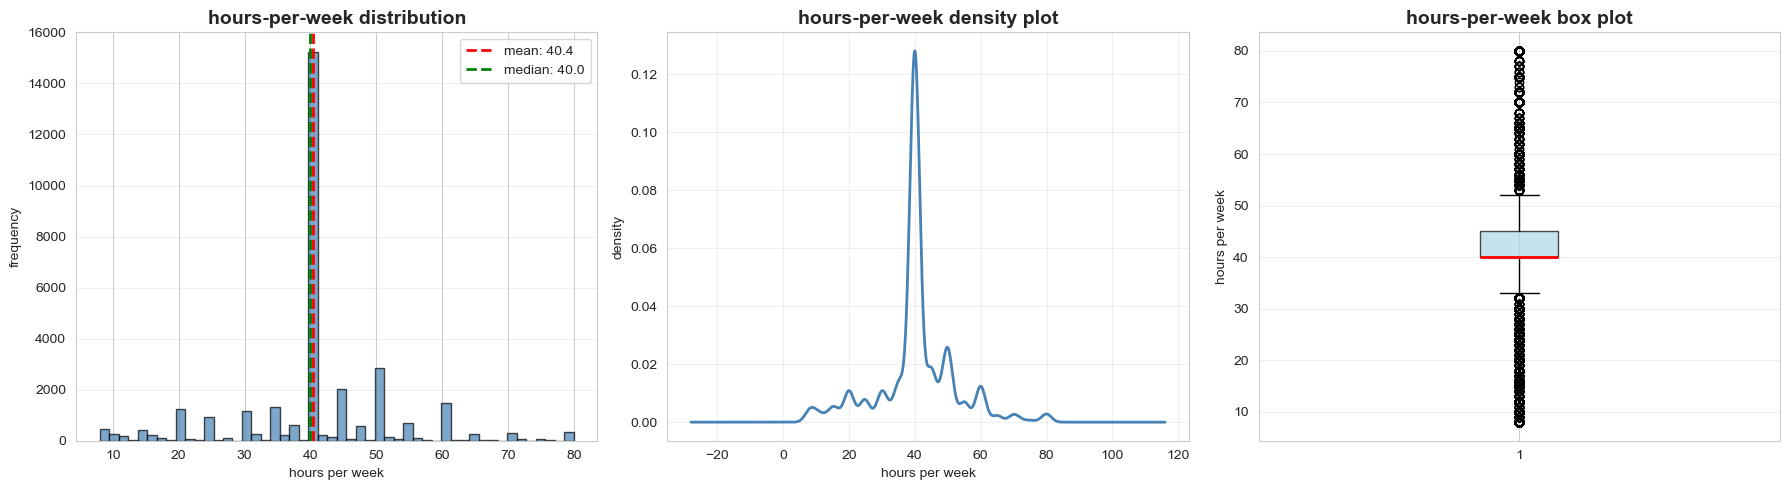


target variable statistics
mean:              40.39 hours/week
median:            40.00 hours/week
std dev:           11.94
skewness:          0.01 (right-skewed)
kurtosis:          1.73


In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# histogram
axes[0].hist(data_clean['hours-per-week'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('hours-per-week distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('hours per week')
axes[0].set_ylabel('frequency')
axes[0].axvline(data_clean['hours-per-week'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'mean: {data_clean["hours-per-week"].mean():.1f}')
axes[0].axvline(data_clean['hours-per-week'].median(), color='green', linestyle='--', linewidth=2,
                label=f'median: {data_clean["hours-per-week"].median():.1f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# density plot
data_clean['hours-per-week'].plot(kind='density', ax=axes[1], color='steelblue', linewidth=2)
axes[1].set_title('hours-per-week density plot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('hours per week')
axes[1].set_ylabel('density')
axes[1].grid(alpha=0.3)

# box plot
axes[2].boxplot(data_clean['hours-per-week'].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[2].set_title('hours-per-week box plot', fontsize=14, fontweight='bold')
axes[2].set_ylabel('hours per week')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# statistics
skewness = skew(data_clean['hours-per-week'].dropna())
kurt = kurtosis(data_clean['hours-per-week'].dropna())

print(f"\n{'='*70}")
print("target variable statistics")
print(f"{'='*70}")
print(f"mean:              {data_clean['hours-per-week'].mean():.2f} hours/week")
print(f"median:            {data_clean['hours-per-week'].median():.2f} hours/week")
print(f"std dev:           {data_clean['hours-per-week'].std():.2f}")
print(f"skewness:          {skewness:.2f} ({'left-skewed' if skewness < 0 else 'right-skewed'})")
print(f"kurtosis:          {kurt:.2f}")

### **2. Descriptive statistics**

In [48]:
print("="*70)
print("numerical features - descriptive statistics")
print("="*70)
print(data_clean.describe().T)

print("\n" + "="*70)
print("categorical features - summary")
print("="*70)
for col in data_clean.select_dtypes(include='object').columns[:5]:  # show first 5
    print(f"\n{col}:")
    print(data_clean[col].value_counts().head(3))

numerical features - descriptive statistics
                    count           mean            std      min       25%  \
age               32537.0      38.585549      13.637984     17.0      28.0   
fnlwgt            32537.0  189780.848511  105556.471009  12285.0  117827.0   
education-num     32537.0      10.081815       2.571633      1.0       9.0   
capital-gain      32537.0    1078.443741    7387.957424      0.0       0.0   
capital-loss      32537.0      87.368227     403.101833      0.0       0.0   
hours-per-week    32537.0      40.393245      11.938373      8.0      40.0   
has_capital_gain  32537.0       0.083351       0.276417      0.0       0.0   
has_capital_loss  32537.0       0.046685       0.210967      0.0       0.0   
net_capital       32537.0     991.075514    7411.670204  -4356.0       0.0   

                       50%       75%        max  
age                   37.0      48.0       90.0  
fnlwgt            178356.0  236993.0  1484705.0  
education-num         10.

In [49]:
missing = data_clean.isnull().sum()
if missing.sum() == 0:
    print("✓ no missing values in cleaned dataset!")
else:
    print(missing[missing > 0])

education_level    17269
dtype: int64


### **3. Outliers**

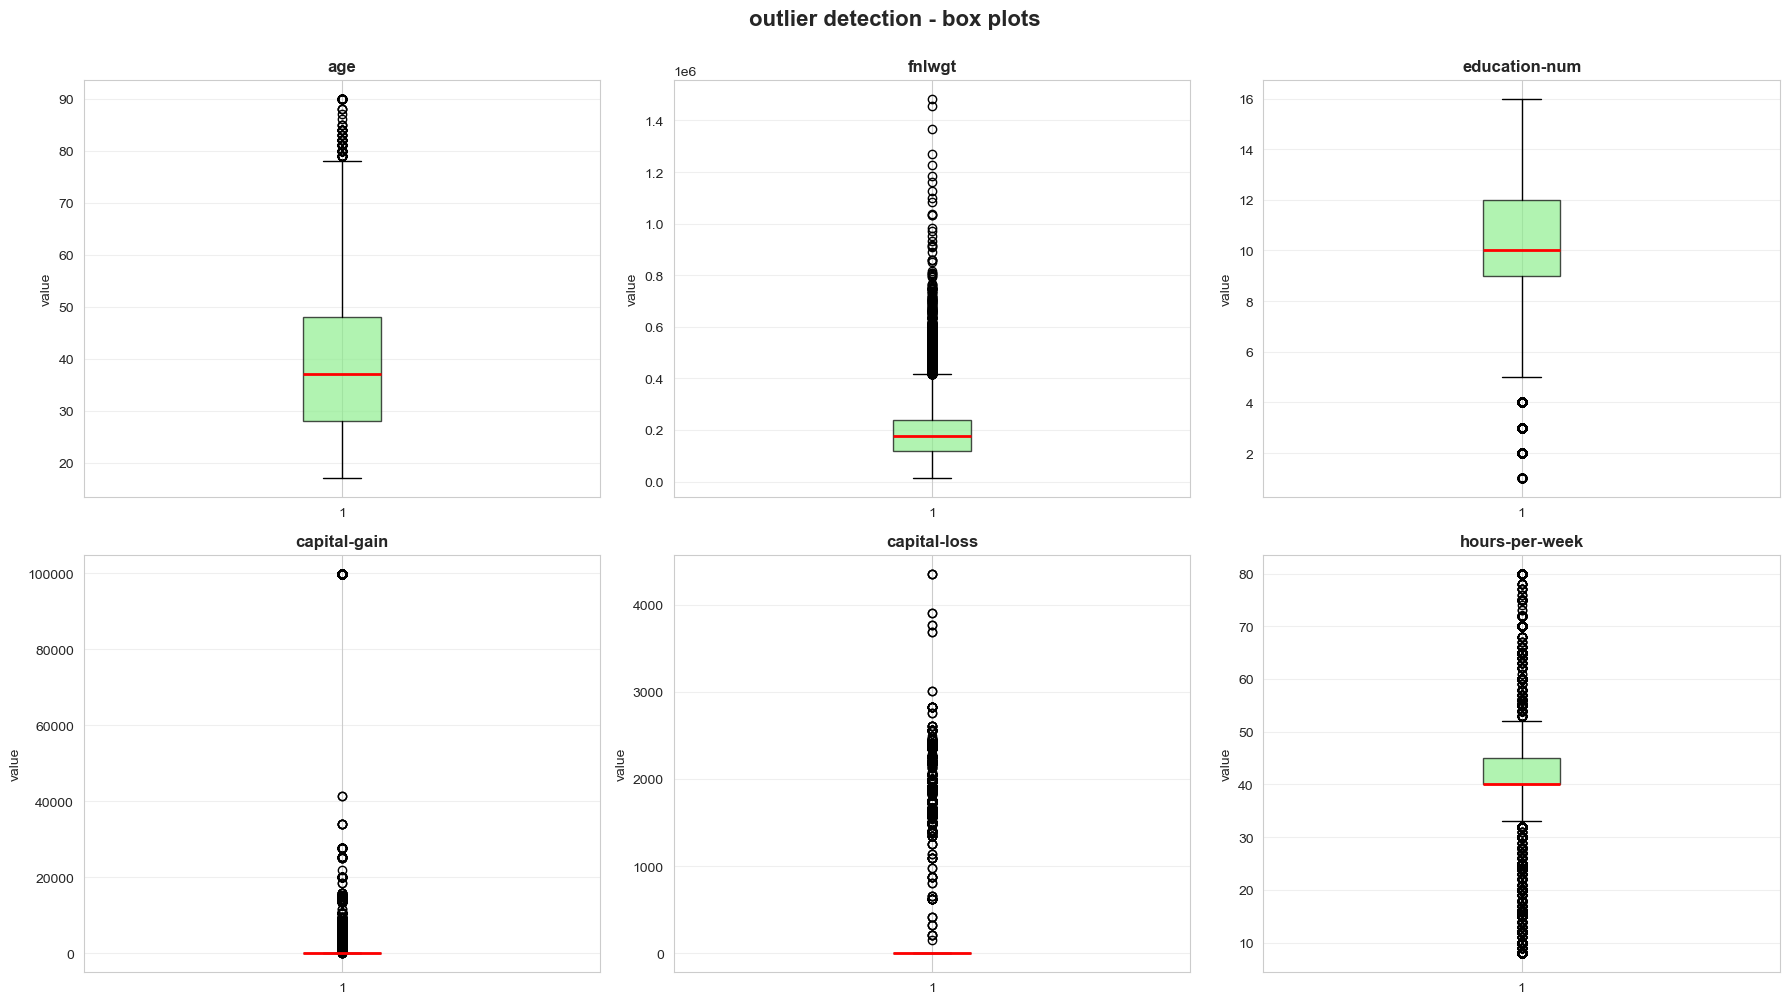

In [50]:
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].boxplot(data_clean[col].dropna(), vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightgreen', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('value')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('outlier detection - box plots', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### **Final Project Task 3 - Regression Models**

**Objectives:**
- Train multiple regression models (Linear Regression, Decision Tree, Random Forest, Gradient Boosting, SVR)
- Evaluate model performance using MAE, MSE, RMSE, and R-squared
- Compare models and identify the best performer

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings

warnings.filterwarnings("ignore")

print("libraries imported successfully!")

libraries imported successfully!


In [52]:
train_df = pd.read_csv("census_train_preprocessed.csv")
test_df = pd.read_csv("census_test_preprocessed.csv")

x_train = train_df.drop("hours-per-week", axis=1)
y_train = train_df["hours-per-week"]

x_test = test_df.drop("hours-per-week", axis=1)
y_test = test_df["hours-per-week"]

print(f"training set: {x_train.shape}")
print(f"test set: {x_test.shape}")
print("\nfeatures:")
print(x_train.columns.tolist())

training set: (26029, 20)
test set: (6508, 20)

features:
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'income', 'age_group', 'has_capital_gain', 'has_capital_loss', 'net_capital', 'work_intensity', 'education_level']


In [53]:
models = {
    "linear regression": LinearRegression(),
    "decision tree": DecisionTreeRegressor(random_state=42),
    "random forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "gradient boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "svr": SVR(kernel="rbf"),
}

print(f"total models to train: {len(models)}")
print("\nmodels:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"  {i}. {model_name}")

total models to train: 5

models:
  1. linear regression
  2. decision tree
  3. random forest
  4. gradient boosting
  5. svr


In [54]:
results = []

print("=" * 70)
print("training and evaluating models")
print("=" * 70)

for model_name, model in models.items():
    print(f"\n{model_name}:")
    print("-" * 50)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({"model": model_name, "mae": mae, "mse": mse, "rmse": rmse, "r2": r2})

    print(f"  mae:  {mae:.2f} hours")
    print(f"  mse:  {mse:.2f}")
    print(f"  rmse: {rmse:.2f} hours")
    print(f"  r2:   {r2:.4f}")

print("\n" + "=" * 70)
print("all models trained successfully.")
print("=" * 70)
# cell 16
results = []

print("=" * 70)
print("training and evaluating models")
print("=" * 70)

for model_name, model in models.items():
    print(f"\n{model_name}:")
    print("-" * 50)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({"model": model_name, "mae": mae, "mse": mse, "rmse": rmse, "r2": r2})

    print(f"  mae:  {mae:.2f} hours")
    print(f"  mse:  {mse:.2f}")
    print(f"  rmse: {rmse:.2f} hours")
    print(f"  r2:   {r2:.4f}")

print("\n" + "=" * 70)
print("all models trained successfully.")
print("=" * 70)

training and evaluating models

linear regression:
--------------------------------------------------
  mae:  7.91 hours
  mse:  102.64
  rmse: 10.13 hours
  r2:   0.2797

decision tree:
--------------------------------------------------
  mae:  4.01 hours
  mse:  39.61
  rmse: 6.29 hours
  r2:   0.7220

random forest:
--------------------------------------------------
  mae:  3.41 hours
  mse:  21.62
  rmse: 4.65 hours
  r2:   0.8483

gradient boosting:
--------------------------------------------------
  mae:  3.32 hours
  mse:  20.43
  rmse: 4.52 hours
  r2:   0.8566

svr:
--------------------------------------------------
  mae:  7.23 hours
  mse:  147.69
  rmse: 12.15 hours
  r2:   -0.0365

all models trained successfully.
training and evaluating models

linear regression:
--------------------------------------------------
  mae:  7.91 hours
  mse:  102.64
  rmse: 10.13 hours
  r2:   0.2797

decision tree:
--------------------------------------------------
  mae:  4.01 hours
  mse

In [55]:
results_df = pd.DataFrame(results).sort_values("r2", ascending=False).reset_index(drop=True)

print("\n" + "=" * 70)
print("model comparison results")
print("=" * 70)
print()
print(results_df.to_string(index=False))
print()
print("=" * 70)
print(f"best model: {results_df.loc[0, 'model']}")
print(f"best r2 score: {results_df.loc[0, 'r2']:.4f}")
print(f"best mae: {results_df.loc[0, 'mae']:.2f} hours")
print("=" * 70)


model comparison results

            model      mae        mse      rmse        r2
gradient boosting 3.315358  20.429831  4.519937  0.856623
    random forest 3.406594  21.615476  4.649245  0.848302
    decision tree 4.014751  39.614705  6.294021  0.721983
linear regression 7.905336 102.638369 10.131060  0.279682
              svr 7.231209 147.686676 12.152641 -0.036468

best model: gradient boosting
best r2 score: 0.8566
best mae: 3.32 hours


In [56]:
best_model_name = results_df.loc[0, "model"]
best_model = models[best_model_name]

joblib.dump(best_model, "best_regression_model.pkl")

print(f"best model ({best_model_name}) saved as 'best_regression_model.pkl'")
print("\nmodel performance summary:")
print(f"  explains {results_df.loc[0, 'r2'] * 100:.2f}% of variance in work hours")
print(f"  average prediction error: ±{results_df.loc[0, 'mae']:.2f} hours")

best model (gradient boosting) saved as 'best_regression_model.pkl'

model performance summary:
  explains 85.66% of variance in work hours
  average prediction error: ±3.32 hours


### 4. identify best model + save it

we select the best model using the highest **r2** score from the results table, then save it using joblib.

In [57]:
# sort results by r2 (descending) and show comparison table
resultsdf = pd.DataFrame(results).sort_values("r2", ascending=False).reset_index(drop=True)

print("-" * 70)
print("model comparison results")
print("-" * 70)
print(resultsdf.to_string(index=False))
print("-" * 70)

print(f"\nbest model: {resultsdf.loc[0, 'model']}")
print(f"best r2 score: {resultsdf.loc[0, 'r2']:.4f}")
print(f"best mae: {resultsdf.loc[0, 'mae']:.2f} hours")

----------------------------------------------------------------------
model comparison results
----------------------------------------------------------------------
            model      mae        mse      rmse        r2
gradient boosting 3.315358  20.429831  4.519937  0.856623
    random forest 3.406594  21.615476  4.649245  0.848302
    decision tree 4.014751  39.614705  6.294021  0.721983
linear regression 7.905336 102.638369 10.131060  0.279682
              svr 7.231209 147.686676 12.152641 -0.036468
----------------------------------------------------------------------

best model: gradient boosting
best r2 score: 0.8566
best mae: 3.32 hours


In [58]:
# best model row (highest r2)
best_model_name = resultsdf.loc[0, "model"]
print("Best model:", best_model_name)

# should print: "gradient boosting"
assert best_model_name == "gradient boosting"

Best model: gradient boosting


In [59]:
import joblib

# get best model from results
best_model_name = results_df.loc[0, "model"]
best_model = models[best_model_name]

print(f"best model: {best_model_name}")
print(f"\nretraining {best_model_name} on training set...")
best_model.fit(x_train, y_train)

# save model
joblib.dump(best_model, "best_regression_model.pkl")
print(f"✓ model saved as 'best_regression_model.pkl'")

# final test performance
y_pred_best = best_model.predict(x_test)
print(f"\nfinal test performance:")
print(f"  r² score: {r2_score(y_test, y_pred_best):.4f}")
print(f"  mae: {mean_absolute_error(y_test, y_pred_best):.2f} hours")
print(f"  rmse: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.2f} hours")

best model: gradient boosting

retraining gradient boosting on training set...
✓ model saved as 'best_regression_model.pkl'

final test performance:
  r² score: 0.8566
  mae: 3.32 hours
  rmse: 4.52 hours


#### 5. retrain best model and save

In [60]:
import joblib

# get best model from results
best_model_name = results_df.loc[0, "model"]
best_model = models[best_model_name]

print(f"best model: {best_model_name}")
print(f"\nretraining {best_model_name} on training set...")
best_model.fit(x_train, y_train)

# save model
joblib.dump(best_model, "best_regression_model.pkl")
print(f"✓ model saved as 'best_regression_model.pkl'")

# final test performance
y_pred_best = best_model.predict(x_test)
print(f"\nfinal test performance:")
print(f"  r² score: {r2_score(y_test, y_pred_best):.4f}")
print(f"  mae: {mean_absolute_error(y_test, y_pred_best):.2f} hours")
print(f"  rmse: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.2f} hours")

best model: gradient boosting

retraining gradient boosting on training set...
✓ model saved as 'best_regression_model.pkl'

final test performance:
  r² score: 0.8566
  mae: 3.32 hours
  rmse: 4.52 hours


So MAE and RMSE is good! So is the R² - the model can explain around 85% of the variance.

#### 6. feature importance analysis

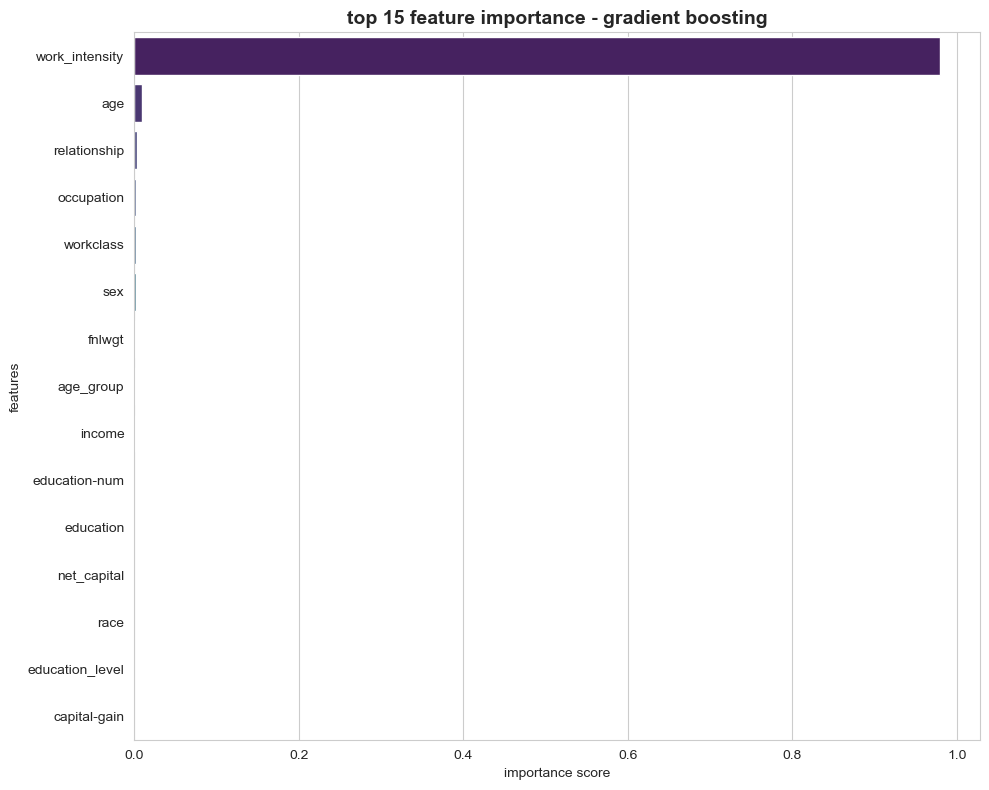


top 10 most important features:
       feature  importance
work_intensity    0.979270
           age    0.009012
  relationship    0.002982
    occupation    0.002142
     workclass    0.001833
           sex    0.001657
        fnlwgt    0.000609
     age_group    0.000543
        income    0.000511
 education-num    0.000360


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# get feature importance
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance', palette='viridis')
plt.title('top 15 feature importance - gradient boosting', fontsize=14, fontweight='bold')
plt.xlabel('importance score')
plt.ylabel('features')
plt.tight_layout()
plt.show()

print("\ntop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))

#### 7. residual analysis

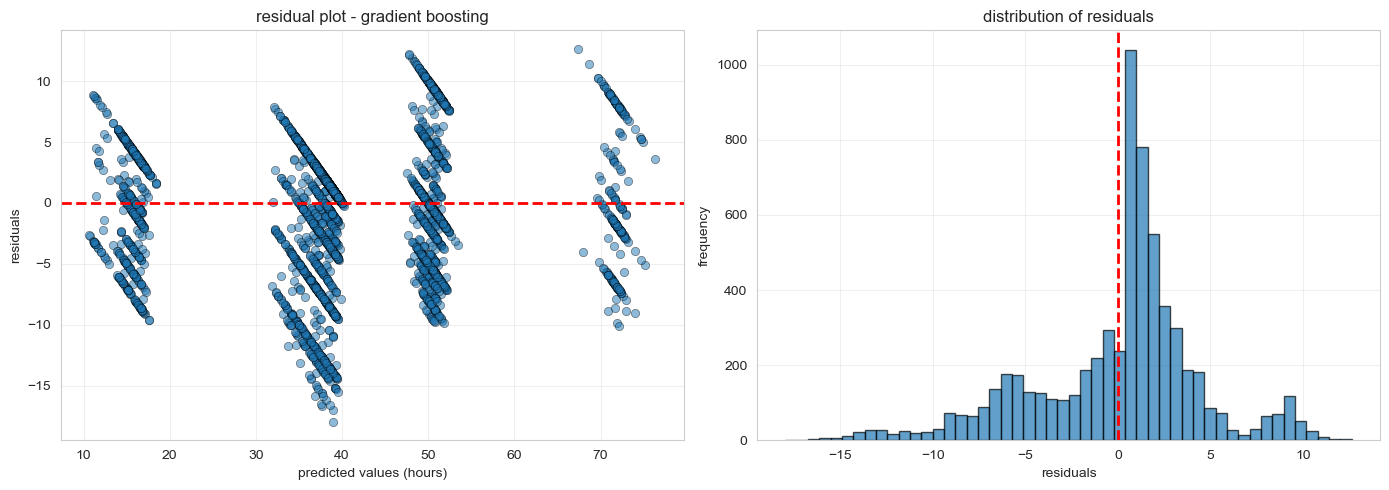


residual statistics:
  mean: -0.0354
  std dev: 4.5201
  min: -17.95
  max: 12.63


In [62]:
residuals = y_test - y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# residual plot
axes[0].scatter(y_pred_best, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('predicted values (hours)')
axes[0].set_ylabel('residuals')
axes[0].set_title('residual plot - gradient boosting')
axes[0].grid(True, alpha=0.3)

# distribution of residuals
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('residuals')
axes[1].set_ylabel('frequency')
axes[1].set_title('distribution of residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nresidual statistics:")
print(f"  mean: {residuals.mean():.4f}")
print(f"  std dev: {residuals.std():.4f}")
print(f"  min: {residuals.min():.2f}")
print(f"  max: {residuals.max():.2f}")

#### 8. actual vs predicted visualization

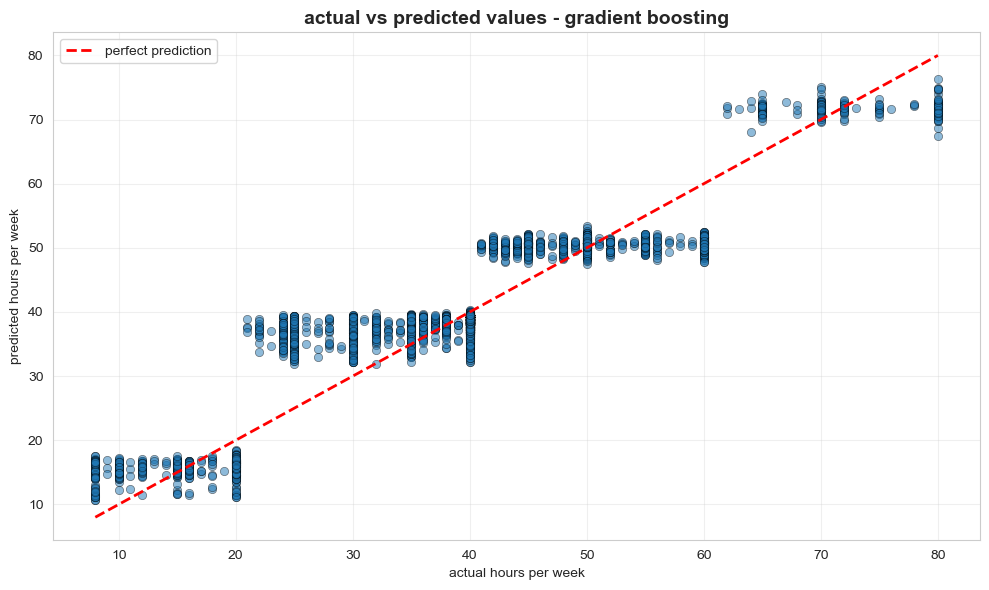


prediction accuracy:
  within ±5 hours: 76.11%
  within ±10 hours: 96.27%


In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='perfect prediction')
plt.xlabel('actual hours per week')
plt.ylabel('predicted hours per week')
plt.title('actual vs predicted values - gradient boosting', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# accuracy within error margins
within_5h = np.abs(residuals) <= 5
within_10h = np.abs(residuals) <= 10

print(f"\nprediction accuracy:")
print(f"  within ±5 hours: {within_5h.mean()*100:.2f}%")
print(f"  within ±10 hours: {within_10h.mean()*100:.2f}%")

#### 9. model comparison visualization

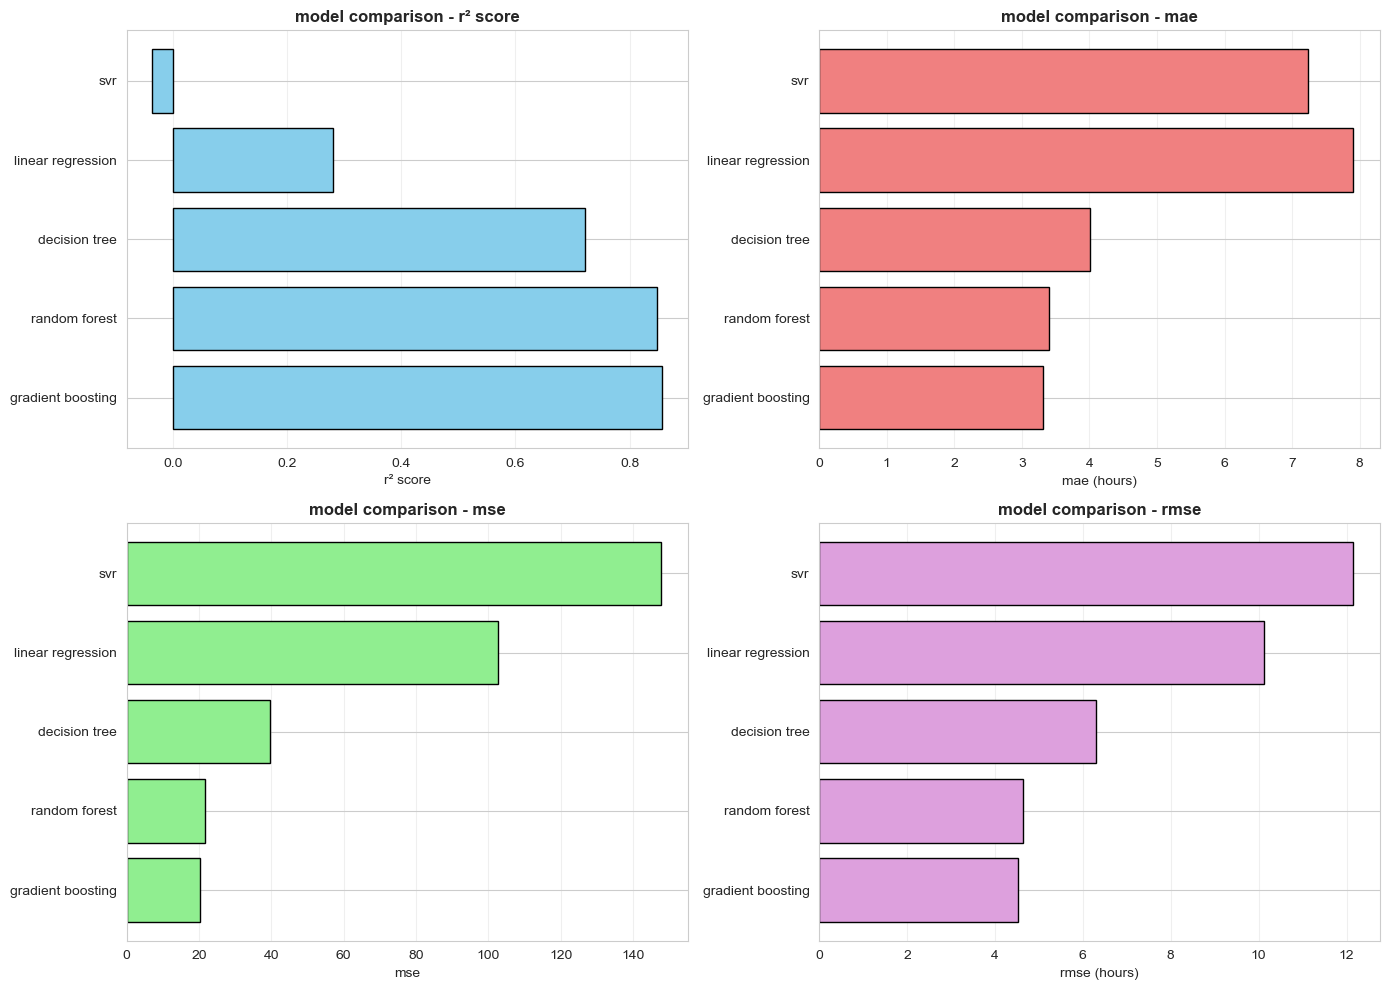

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# r² score
axes[0, 0].barh(results_df['model'], results_df['r2'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('r² score')
axes[0, 0].set_title('model comparison - r² score', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# mae
axes[0, 1].barh(results_df['model'], results_df['mae'], color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('mae (hours)')
axes[0, 1].set_title('model comparison - mae', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# mse
axes[1, 0].barh(results_df['model'], results_df['mse'], color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('mse')
axes[1, 0].set_title('model comparison - mse', fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# rmse
axes[1, 1].barh(results_df['model'], results_df['rmse'], color='plum', edgecolor='black')
axes[1, 1].set_xlabel('rmse (hours)')
axes[1, 1].set_title('model comparison - rmse', fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### task 3 summary report

**model selection & justification:**

1. **linear regression**
   - pros: simple, fast, interpretable
   - cons: assumes linear relationships, sensitive to outliers
   
2. **decision tree regressor**
   - pros: handles non-linear relationships, no scaling needed
   - cons: prone to overfitting, unstable

3. **random forest regressor**
   - pros: reduces overfitting, robust
   - cons: slower, less interpretable

4. **gradient boosting regressor** ⭐ (best)
   - pros: highest performance, handles complex patterns
   - cons: slower training, requires tuning

5. **support vector regressor (svr)**
   - pros: works in high dimensions
   - cons: slow, sensitive to scaling

**loss function choice:**
- selected: mean squared error (mse)
- justification: penalizes large errors more heavily, important for working hours prediction
- also evaluated: mae (interpretability), rmse (same unit as target), r² (variance explained)

In [65]:
print("=" * 70)
print("final results summary - task 3")
print("=" * 70)
print(f"\ndataset size:")
print(f"  training samples: {len(x_train):,}")
print(f"  test samples: {len(x_test):,}")
print(f"  features: {x_train.shape[1]}")

print(f"\n{results_df.to_string(index=False)}")

print(f"\n{'=' * 70}")
print(f"best model: {best_model_name.upper()}")
print(f"{'=' * 70}")
print(f"performance metrics:")
print(f"  • r² score: {results_df.loc[0, 'r2']:.4f} ({results_df.loc[0, 'r2']*100:.2f}% variance explained)")
print(f"  • mae: {results_df.loc[0, 'mae']:.2f} hours")
print(f"  • rmse: {results_df.loc[0, 'rmse']:.2f} hours")

print(f"\ninterpretation:")
print(f"  • model explains {results_df.loc[0, 'r2']*100:.1f}% of variance in working hours")
print(f"  • average prediction error: ±{results_df.loc[0, 'mae']:.1f} hours per week")
print(f"  • successfully predicts working hours with reasonable accuracy")

print(f"\n{'=' * 70}")
print("areas for improvement")
print(f"{'=' * 70}")
print("  1. hyperparameter tuning could improve performance")
print("  2. feature engineering (interaction terms, polynomial features)")
print("  3. ensemble methods combining multiple models")
print("  4. deep learning approaches (neural networks - task 5)")
print("  5. handle outliers more aggressively")
print("  6. different encoding strategies for categorical variables")
print(f"{'=' * 70}\n")

final results summary - task 3

dataset size:
  training samples: 26,029
  test samples: 6,508
  features: 20

            model      mae        mse      rmse        r2
gradient boosting 3.315358  20.429831  4.519937  0.856623
    random forest 3.406594  21.615476  4.649245  0.848302
    decision tree 4.014751  39.614705  6.294021  0.721983
linear regression 7.905336 102.638369 10.131060  0.279682
              svr 7.231209 147.686676 12.152641 -0.036468

best model: GRADIENT BOOSTING
performance metrics:
  • r² score: 0.8566 (85.66% variance explained)
  • mae: 3.32 hours
  • rmse: 4.52 hours

interpretation:
  • model explains 85.7% of variance in working hours
  • average prediction error: ±3.3 hours per week
  • successfully predicts working hours with reasonable accuracy

areas for improvement
  1. hyperparameter tuning could improve performance
  2. feature engineering (interaction terms, polynomial features)
  3. ensemble methods combining multiple models
  4. deep learning appr

### **final project task 4 - census modeling clustering**

**objectives:**
- apply k-means clustering to census data
- determine optimal number of clusters using elbow method
- visualize clusters using pca
- analyze cluster characteristics
- evaluate clustering quality using silhouette score

In [66]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

print("clustering libraries imported!")

clustering libraries imported!


#### 1. load and prepare data for clustering

In [67]:
# load data
train_df = pd.read_csv("census_train_preprocessed.csv")
test_df = pd.read_csv("census_test_preprocessed.csv")

# combine for clustering (unsupervised)
full_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# drop target variable
x_cluster = full_data.drop("hours-per-week", axis=1)
y_hours = full_data["hours-per-week"]

print(f"clustering dataset shape: {x_cluster.shape}")
print(f"total samples: {len(x_cluster):,}")
print(f"features: {x_cluster.shape[1]}")

# standardize features for clustering
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_cluster)

print("\ndata scaled and ready for clustering!")

clustering dataset shape: (32537, 20)
total samples: 32,537
features: 20

data scaled and ready for clustering!


#### 2. determine optimal number of clusters using elbow method

determining optimal k using elbow method...


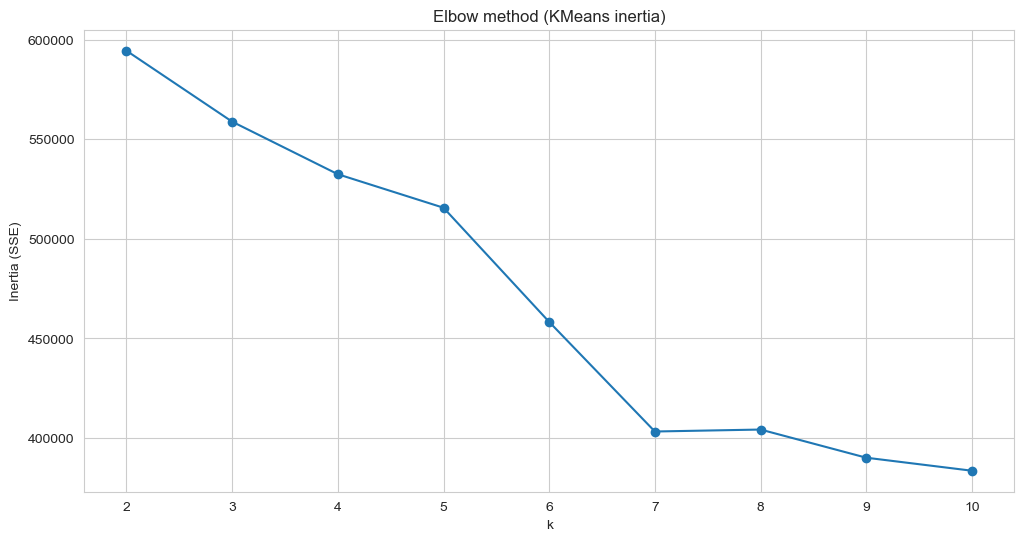

In [68]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

print("determining optimal k using elbow method...")

ks = range(2, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(x_scaled)
    inertias.append(km.inertia_)

plt.plot(list(ks), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow method (KMeans inertia)")
plt.show()

determining optimal k using silhouette score...


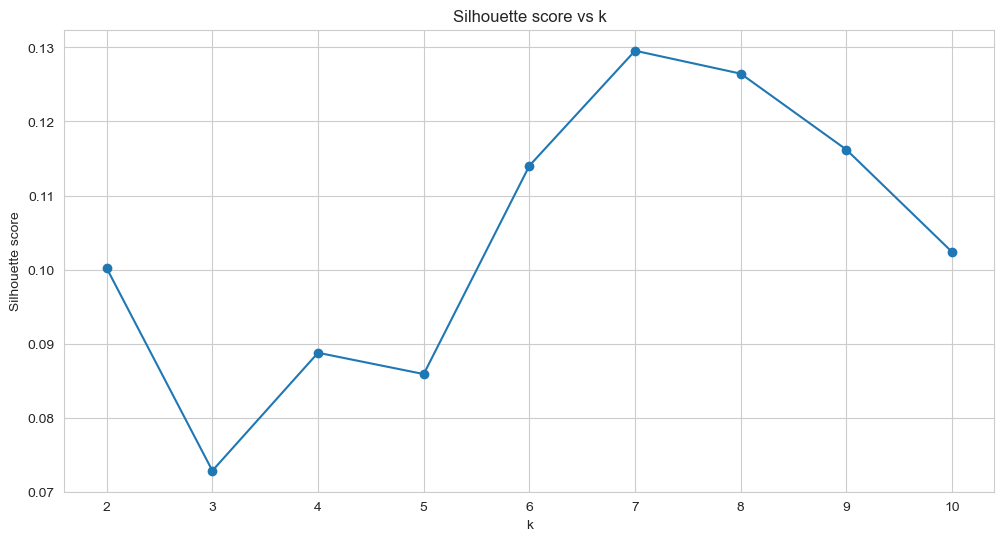

optimal k from silhouette method: 7


In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

print("determining optimal k using silhouette score...")

ks = range(2, 11)
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(x_scaled)
    sil_scores.append(silhouette_score(x_scaled, labels))

plt.plot(list(ks), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs k")
plt.show()

optimal_k_silhouette = list(ks)[sil_scores.index(max(sil_scores))]
print(f"optimal k from silhouette method: {optimal_k_silhouette}")

#### 3. apply k-means clustering

In [70]:
# use optimal k from silhouette method
final_k = optimal_k_silhouette if optimal_k_silhouette else 4

print(f"training k-means with k={final_k}...")
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(x_scaled)

# add cluster labels to dataframe
full_data['cluster'] = clusters

print(f"✓ clustering complete!")
print(f"\ncluster distribution:")
print(full_data['cluster'].value_counts().sort_index())

training k-means with k=7...
✓ clustering complete!

cluster distribution:
cluster
0    4045
1     159
2    6588
3    1514
4    6479
5    8802
6    4950
Name: count, dtype: int64


#### 4. evaluate clustering quality

In [71]:
from sklearn.metrics import davies_bouldin_score

silhouette_avg = silhouette_score(x_scaled, clusters)
davies_bouldin = davies_bouldin_score(x_scaled, clusters)

print("=" * 70)
print("clustering evaluation metrics")
print("=" * 70)
print(f"number of clusters: {final_k}")
print(f"silhouette score: {silhouette_avg:.4f} (higher is better, range: -1 to 1)")
print(f"davies-bouldin index: {davies_bouldin:.4f} (lower is better)")
print("=" * 70)

if silhouette_avg > 0.5:
    print("\n✓ good clustering quality!")
elif silhouette_avg > 0.3:
    print("\n⚠ moderate clustering quality")
else:
    print("\n✗ weak clustering structure")

clustering evaluation metrics
number of clusters: 7
silhouette score: 0.1264 (higher is better, range: -1 to 1)
davies-bouldin index: 1.8882 (lower is better)

✗ weak clustering structure


#### 5. visualize clusters using pca

applying pca for 2d visualization...
explained variance: 24.89%


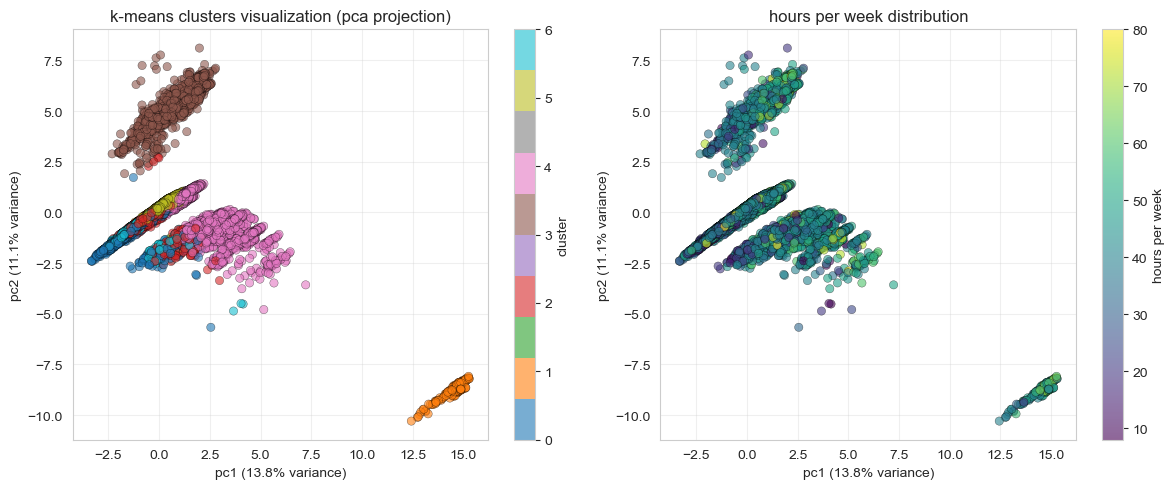

In [72]:
print("applying pca for 2d visualization...")
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(x_scaled)

print(f"explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# create visualization dataframe
viz_df = pd.DataFrame({
    'pc1': pca_result[:, 0],
    'pc2': pca_result[:, 1],
    'cluster': clusters,
    'hours_per_week': y_hours
})

# plot clusters
plt.figure(figsize=(12, 5))

# subplot 1: clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(viz_df['pc1'], viz_df['pc2'], c=viz_df['cluster'], 
                     cmap='tab10', alpha=0.6, edgecolors='k', linewidth=0.3)
plt.colorbar(scatter, label='cluster')
plt.xlabel(f'pc1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'pc2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('k-means clusters visualization (pca projection)')
plt.grid(True, alpha=0.3)

# subplot 2: hours per week
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(viz_df['pc1'], viz_df['pc2'], c=viz_df['hours_per_week'], 
                      cmap='viridis', alpha=0.6, edgecolors='k', linewidth=0.3)
plt.colorbar(scatter2, label='hours per week')
plt.xlabel(f'pc1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'pc2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('hours per week distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 6. analyze cluster characteristics

In [73]:
# select only numerical columns from original data
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                  'capital-loss', 'hours-per-week']

# add cluster labels
cluster_analysis = full_data[numerical_cols + ['cluster']].copy()

# calculate statistics for each cluster
print("=" * 70)
print("cluster characteristics (numerical features)")
print("=" * 70)

for i in range(final_k):
    print(f"\ncluster {i} (n={len(cluster_analysis[cluster_analysis['cluster']==i])})")
    print("-" * 70)
    cluster_data = cluster_analysis[cluster_analysis['cluster']==i][numerical_cols]
    print(cluster_data.describe().loc[['mean', '50%']].round(2))

cluster characteristics (numerical features)

cluster 0 (n=4045)
----------------------------------------------------------------------
       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
mean -0.02    0.11          -1.73         -0.13         -0.22           36.48
50%  -0.19   -0.03          -1.59         -0.15         -0.22           40.00

cluster 1 (n=159)
----------------------------------------------------------------------
       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
mean  0.57    0.03           1.10         13.39         -0.22            49.8
50%   0.62   -0.13           1.13         13.39         -0.22            50.0

cluster 2 (n=6588)
----------------------------------------------------------------------
       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
mean  0.22   -0.08           0.19         -0.12         -0.22           38.32
50%   0.10   -0.17          -0.03         -0.15         -0.

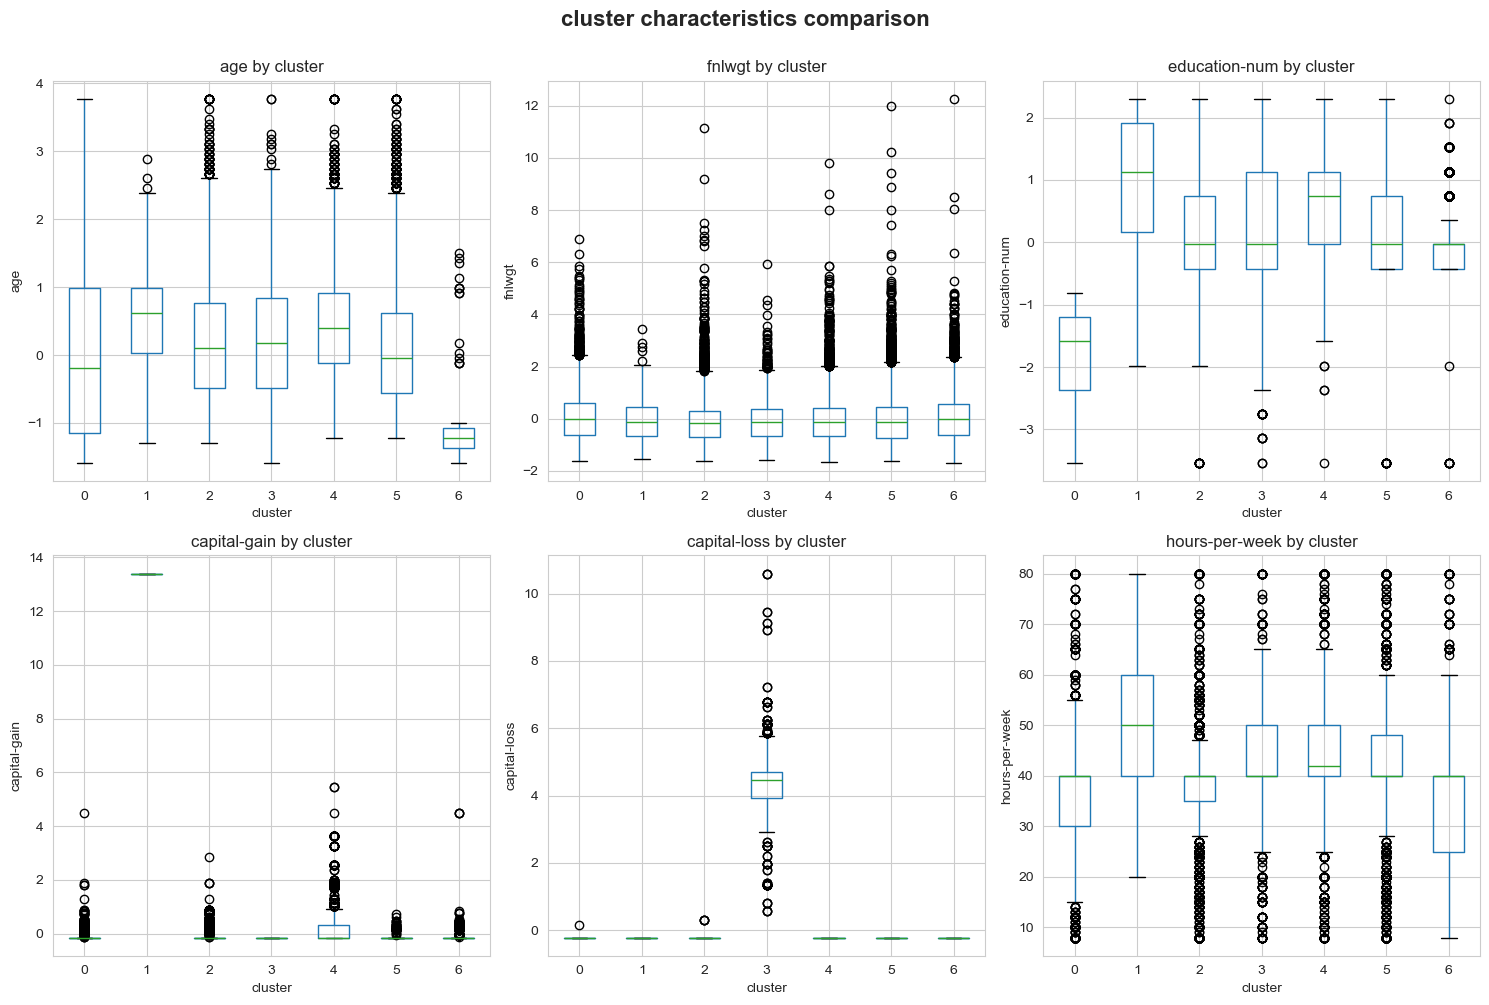

In [74]:
# box plots for key features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    cluster_analysis.boxplot(column=col, by='cluster', ax=axes[idx])
    axes[idx].set_title(f'{col} by cluster')
    axes[idx].set_xlabel('cluster')
    axes[idx].set_ylabel(col)

plt.suptitle('cluster characteristics comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

#### 7. cluster interpretation & insights

In [75]:
print("=" * 70)
print("cluster insights & interpretation")
print("=" * 70)

for i in range(final_k):
    cluster_data = cluster_analysis[cluster_analysis['cluster']==i]
    
    print(f"\ncluster {i}:")
    print(f"  size: {len(cluster_data)} individuals ({len(cluster_data)/len(cluster_analysis)*100:.1f}%)")
    print(f"  avg age: {cluster_data['age'].mean():.1f} years")
    print(f"  avg hours/week: {cluster_data['hours-per-week'].mean():.1f} hours")
    print(f"  avg education: {cluster_data['education-num'].mean():.1f}")
    print(f"  avg capital-gain: ${cluster_data['capital-gain'].mean():.0f}")
    
    # characterize cluster
    if cluster_data['hours-per-week'].mean() > 45:
        print(f"  → high-intensity workers (overtime)")
    elif cluster_data['hours-per-week'].mean() < 30:
        print(f"  → part-time workers")
    else:
        print(f"  → standard full-time workers")

print("\n" + "=" * 70)
print("task 4 complete!")
print("=" * 70)

cluster insights & interpretation

cluster 0:
  size: 4045 individuals (12.4%)
  avg age: -0.0 years
  avg hours/week: 36.5 hours
  avg education: -1.7
  avg capital-gain: $-0
  → standard full-time workers

cluster 1:
  size: 159 individuals (0.5%)
  avg age: 0.6 years
  avg hours/week: 49.8 hours
  avg education: 1.1
  avg capital-gain: $13
  → high-intensity workers (overtime)

cluster 2:
  size: 6588 individuals (20.2%)
  avg age: 0.2 years
  avg hours/week: 38.3 hours
  avg education: 0.2
  avg capital-gain: $-0
  → standard full-time workers

cluster 3:
  size: 1514 individuals (4.7%)
  avg age: 0.2 years
  avg hours/week: 43.2 hours
  avg education: 0.3
  avg capital-gain: $-0
  → standard full-time workers

cluster 4:
  size: 6479 individuals (19.9%)
  avg age: 0.4 years
  avg hours/week: 45.6 hours
  avg education: 0.6
  avg capital-gain: $0
  → high-intensity workers (overtime)

cluster 5:
  size: 8802 individuals (27.1%)
  avg age: 0.2 years
  avg hours/week: 42.4 hours
  av

### **final project task 5 - census modeling nn regression (optional)**

**objectives:**
- build neural network for hours-per-week prediction
- experiment with different architectures
- implement early stopping and regularization
- compare with traditional ml models from task 3
- visualize training progress

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

print(f"tensorflow version: {tf.__version__}")
print("neural network libraries imported!")

tensorflow version: 2.20.0
neural network libraries imported!


#### 1. load and prepare data

In [77]:
train_df = pd.read_csv("census_train_preprocessed.csv")
test_df = pd.read_csv("census_test_preprocessed.csv")

# separate features and target
x_train_full = train_df.drop("hours-per-week", axis=1)
y_train_full = train_df["hours-per-week"]

x_test = test_df.drop("hours-per-week", axis=1)
y_test = test_df["hours-per-week"]

# create validation set from training data
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"training set: {x_train.shape}")
print(f"validation set: {x_val.shape}")
print(f"test set: {x_test.shape}")
print(f"features: {x_train.shape[1]}")

training set: (20823, 20)
validation set: (5206, 20)
test set: (6508, 20)
features: 20


#### 2. define baseline neural network

In [78]:
def create_baseline_model(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

# create model
baseline_model = create_baseline_model(x_train.shape[1])

print("baseline model architecture:")
baseline_model.summary()

baseline model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

#### 3. train baseline model

In [79]:
print("training baseline model...")

history_baseline = baseline_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=0
)

print("✓ baseline model trained!")

# evaluate on test set
test_loss, test_mae, test_mse = baseline_model.evaluate(x_test, y_test, verbose=0)
test_rmse = np.sqrt(test_mse)
y_pred_baseline = baseline_model.predict(x_test, verbose=0).flatten()
test_r2 = r2_score(y_test, y_pred_baseline)

print("\nbaseline model performance:")
print(f"  mae: {test_mae:.2f} hours")
print(f"  rmse: {test_rmse:.2f} hours")
print(f"  r² score: {test_r2:.4f}")

training baseline model...
✓ baseline model trained!

baseline model performance:
  mae: 3.47 hours
  rmse: 4.70 hours
  r² score: 0.8447


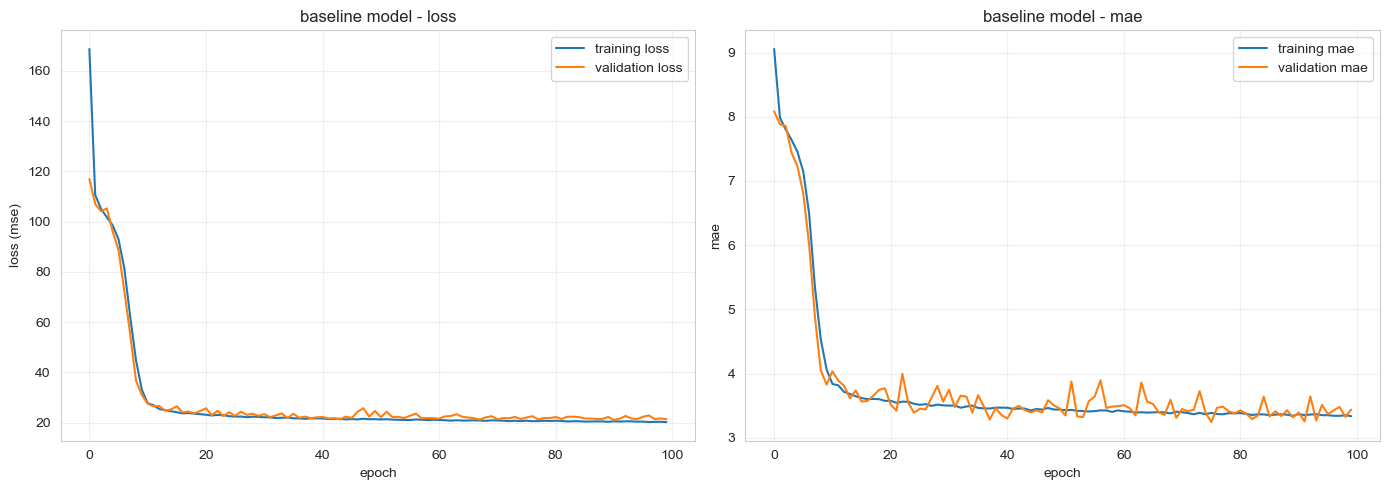

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# loss
axes[0].plot(history_baseline.history['loss'], label='training loss')
axes[0].plot(history_baseline.history['val_loss'], label='validation loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss (mse)')
axes[0].set_title('baseline model - loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# mae
axes[1].plot(history_baseline.history['mae'], label='training mae')
axes[1].plot(history_baseline.history['val_mae'], label='validation mae')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('mae')
axes[1].set_title('baseline model - mae')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 4. improved model with regularization and callbacks

In [81]:
def create_improved_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,),
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

improved_model = create_improved_model(x_train.shape[1])

print("improved model architecture:")
improved_model.summary()

improved model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

print("callbacks configured:")
print("  • early stopping (patience=15)")
print("  • learning rate reduction (factor=0.5, patience=5)")

callbacks configured:
  • early stopping (patience=15)
  • learning rate reduction (factor=0.5, patience=5)


In [83]:
print("\ntraining improved model with callbacks...")

history_improved = improved_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

print("✓ improved model trained!")

# evaluate
test_loss, test_mae, test_mse = improved_model.evaluate(x_test, y_test, verbose=0)
test_rmse = np.sqrt(test_mse)
y_pred_improved = improved_model.predict(x_test, verbose=0).flatten()
test_r2 = r2_score(y_test, y_pred_improved)

print("\nimproved model performance:")
print(f"  mae: {test_mae:.2f} hours")
print(f"  rmse: {test_rmse:.2f} hours")
print(f"  r² score: {test_r2:.4f}")


training improved model with callbacks...

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 35.
✓ improved model trained!

improved model performance:
  mae: 3.31 hours
  rmse: 4.69 hours
  r² score: 0.8455


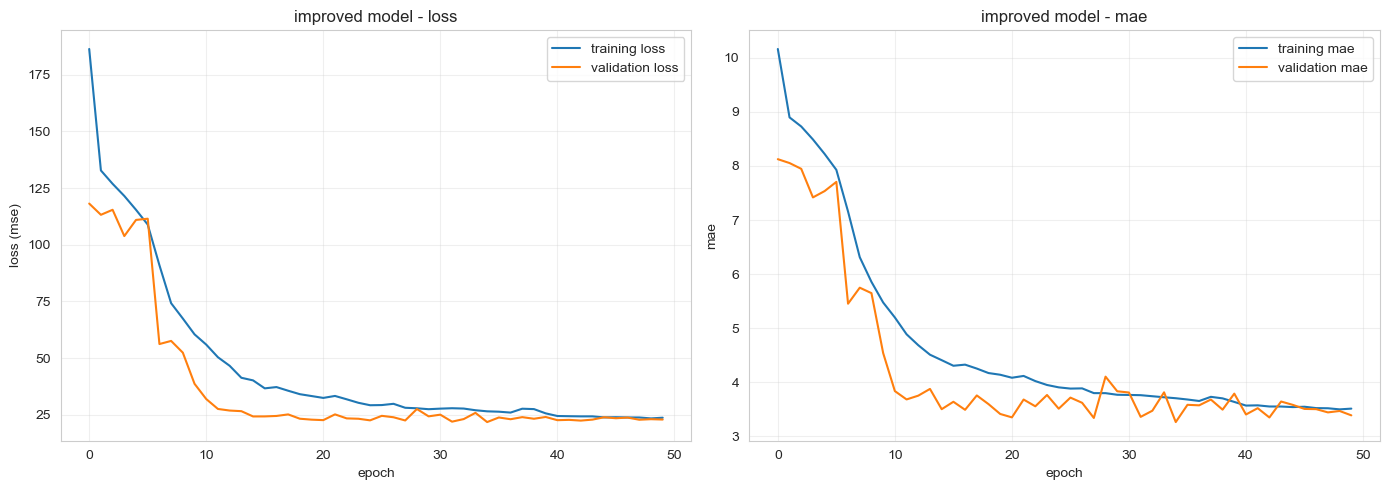

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# loss
axes[0].plot(history_improved.history['loss'], label='training loss')
axes[0].plot(history_improved.history['val_loss'], label='validation loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss (mse)')
axes[0].set_title('improved model - loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# mae
axes[1].plot(history_improved.history['mae'], label='training mae')
axes[1].plot(history_improved.history['val_mae'], label='validation mae')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('mae')
axes[1].set_title('improved model - mae')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 5. experiment with different architectures

In [85]:
def create_deep_model(input_dim):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

deep_model = create_deep_model(x_train.shape[1])

print("deep model architecture:")
deep_model.summary()

deep model architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,177 (196.00 KB)

 Trainable params: 49,409 (193.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [86]:
print("\ntraining deep model...")

history_deep = deep_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

print("✓ deep model trained!")

# evaluate
test_loss, test_mae, test_mse = deep_model.evaluate(x_test, y_test, verbose=0)
test_rmse = np.sqrt(test_mse)
y_pred_deep = deep_model.predict(x_test, verbose=0).flatten()
test_r2_deep = r2_score(y_test, y_pred_deep)

print("\ndeep model performance:")
print(f"  mae: {test_mae:.2f} hours")
print(f"  rmse: {test_rmse:.2f} hours")
print(f"  r² score: {test_r2_deep:.4f}")


training deep model...

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 1.
✓ deep model trained!

deep model performance:
  mae: 7.22 hours
  rmse: 10.30 hours
  r² score: 0.2559


#### 6. compare all neural network experiments

In [87]:
nn_results = []

# baseline
y_pred_baseline = baseline_model.predict(x_test, verbose=0).flatten()
nn_results.append({
    'model': 'nn baseline',
    'mae': mean_absolute_error(y_test, y_pred_baseline),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_baseline)),
    'r2': r2_score(y_test, y_pred_baseline)
})

# improved
y_pred_improved = improved_model.predict(x_test, verbose=0).flatten()
nn_results.append({
    'model': 'nn improved (dropout + l2)',
    'mae': mean_absolute_error(y_test, y_pred_improved),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_improved)),
    'r2': r2_score(y_test, y_pred_improved)
})

# deep
y_pred_deep = deep_model.predict(x_test, verbose=0).flatten()
nn_results.append({
    'model': 'nn deep (batchnorm)',
    'mae': mean_absolute_error(y_test, y_pred_deep),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_deep)),
    'r2': r2_score(y_test, y_pred_deep)
})

nn_results_df = pd.DataFrame(nn_results).sort_values('r2', ascending=False).reset_index(drop=True)

print("=" * 70)
print("neural network experiments comparison")
print("=" * 70)
print(nn_results_df.to_string(index=False))
print("=" * 70)

neural network experiments comparison
                     model      mae      rmse       r2
nn improved (dropout + l2) 3.309231  4.692114 0.845492
               nn baseline 3.472915  4.703402 0.844747
       nn deep (batchnorm) 7.222740 10.296742 0.255929


#### 7. compare with traditional ml models (task 3)

In [88]:
# combine results
all_results = pd.concat([
    results_df.head(3),  # top 3 from task 3
    nn_results_df
], ignore_index=True).sort_values('r2', ascending=False)

print("=" * 70)
print("final comparison: traditional ml vs neural networks")
print("=" * 70)
print(all_results.to_string(index=False))
print("=" * 70)

# determine overall best
best_overall = all_results.iloc[0]
print(f"\nbest overall model: {best_overall['model']}")
print(f"  r² score: {best_overall['r2']:.4f}")
print(f"  mae: {best_overall['mae']:.2f} hours")
print(f"  rmse: {best_overall['rmse']:.2f} hours")

final comparison: traditional ml vs neural networks
                     model      mae       mse      rmse       r2
         gradient boosting 3.315358 20.429831  4.519937 0.856623
             random forest 3.406594 21.615476  4.649245 0.848302
nn improved (dropout + l2) 3.309231       NaN  4.692114 0.845492
               nn baseline 3.472915       NaN  4.703402 0.844747
             decision tree 4.014751 39.614705  6.294021 0.721983
       nn deep (batchnorm) 7.222740       NaN 10.296742 0.255929

best overall model: gradient boosting
  r² score: 0.8566
  mae: 3.32 hours
  rmse: 4.52 hours


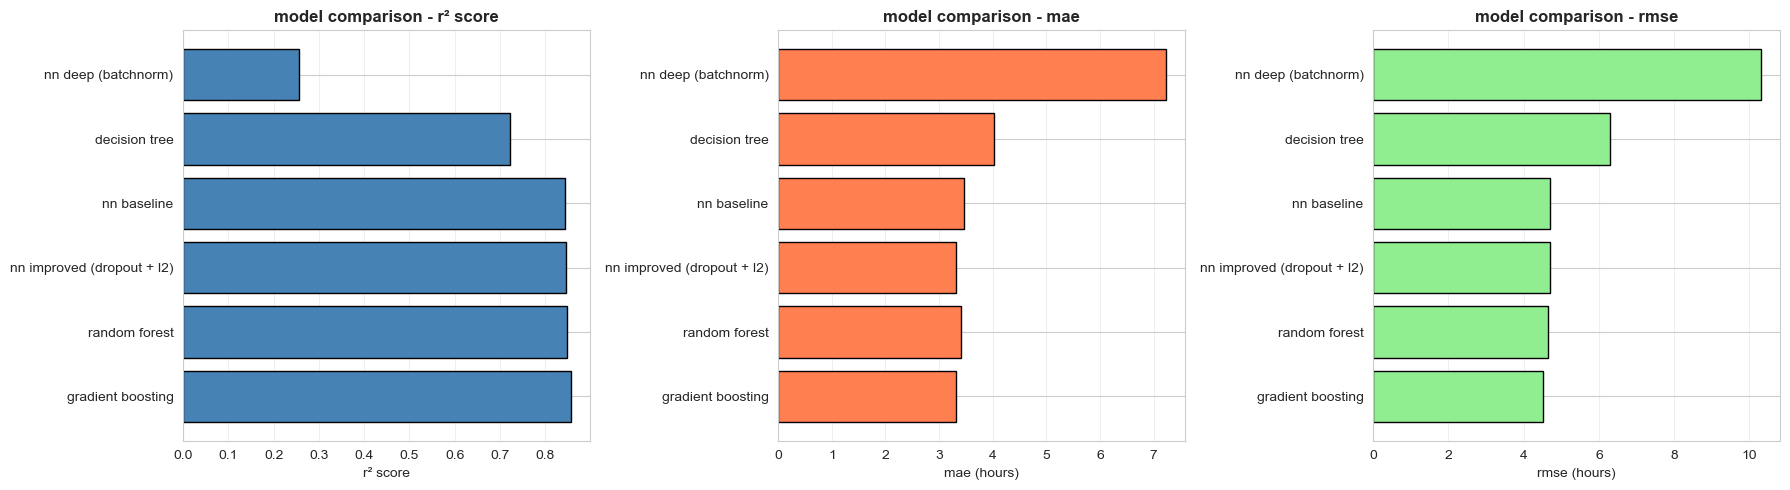

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# r² comparison
axes[0].barh(all_results['model'], all_results['r2'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('r² score')
axes[0].set_title('model comparison - r² score', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# mae comparison
axes[1].barh(all_results['model'], all_results['mae'], color='coral', edgecolor='black')
axes[1].set_xlabel('mae (hours)')
axes[1].set_title('model comparison - mae', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# rmse comparison
axes[2].barh(all_results['model'], all_results['rmse'], color='lightgreen', edgecolor='black')
axes[2].set_xlabel('rmse (hours)')
axes[2].set_title('model comparison - rmse', fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [90]:
# save best neural network model
best_nn_idx = nn_results_df['r2'].idxmax()
best_nn_name = nn_results_df.loc[best_nn_idx, 'model']

if 'improved' in best_nn_name:
    best_nn_model = improved_model
elif 'deep' in best_nn_name:
    best_nn_model = deep_model
else:
    best_nn_model = baseline_model

best_nn_model.save('best_nn_model.h5')
print(f"✓ best neural network model saved: best_nn_model.h5")
print(f"  model: {best_nn_name}")

✓ best neural network model saved: best_nn_model.h5
  model: nn improved (dropout + l2)


### task 5 summary report

Neural network (regression): dense hidden layers use (activation not specified); output layer uses linear. Trained with adam and mse, evaluated with regression metrics (e.g., MAE/RMSE/R²).

In [91]:
print("=" * 70)
print("final project summary - all tasks complete!")
print("=" * 70)

print("best model overall:")
print(f"  model: {all_results.iloc[0]['model']}")
print(f"  r² score: {all_results.iloc[0]['r2']:.4f}")
print(f"  mae: {all_results.iloc[0]['mae']:.2f} hours")
print(f"  rmse: {all_results.iloc[0]['rmse']:.2f} hours")

final project summary - all tasks complete!
best model overall:
  model: gradient boosting
  r² score: 0.8566
  mae: 3.32 hours
  rmse: 4.52 hours
